In [21]:
import numpy as np
import numpy.testing as npt
import xarray as xr
import xrft
import numpy.fft as npft
import scipy.signal as signal
import dask.array as dsar
import matplotlib.pyplot as plt
%matplotlib inline

# Generate generic data centered around zero

In [2]:
k0 = 1/0.52
T = 4.
dx = 0.02
x = np.arange(-2*T,2*T,dx) 
y = np.cos(2*np.pi*k0*x) 
y[np.abs(x)>T/2]=0.
da = xr.DataArray(y, dims=('x',), coords={'x':x})

(-8, 8)

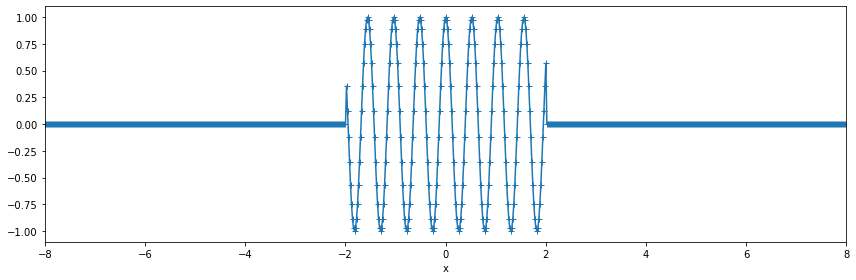

In [3]:
fig, ax = plt.subplots(figsize=(12,4)) 
fig.set_tight_layout(True)
da.plot(ax=ax, marker='+', label='original signal') 
ax.set_xlim([-8,8])

## Let's take the Fourier transform
We will compare the Fourier transform with and without taking into consideration about the phase information.

In [4]:
da_dft = xrft.dft(da, true_phase=True, true_amplitude=True) # Fourier Transform w/ consideration of phase
da_fft = xrft.fft(da)                                       # Fourier Transform with numpy.fft-like behavior
da_npft = npft.fft(da)

In [5]:
k = da_dft.freq_x # wavenumber axis
TF_s = T/2*(np.sinc(T*(k-k0)) + np.sinc(T*(k+k0))) # Theoretical result of the Fourier transform

Text(0.5, 1.0, 'IMAGINARY PART')

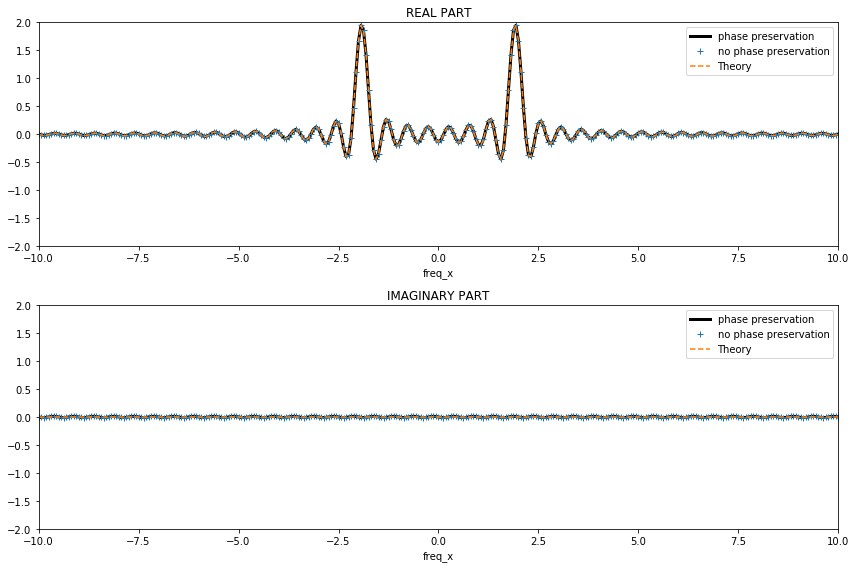

In [6]:
r = (-1)**np.arange(0,len(y))

fig, (ax1,ax2) = plt.subplots(figsize=(12,8), nrows=2, ncols=1)
fig.set_tight_layout(True)

(da_dft.real).plot(ax=ax1, linestyle='-', lw=3, c='k', label='phase preservation') 
(r*(da_fft*dx).real).plot(ax=ax1, linestyle='', marker='+',label='no phase preservation') 
ax1.plot(k, TF_s.real, linestyle='--', label='Theory')
ax1.set_xlim([-10,10])
ax1.set_ylim([-2,2])
ax1.legend()
ax1.set_title('REAL PART')

(da_dft.imag).plot(ax=ax2, linestyle='-', lw=3, c='k', label='phase preservation') 
(r*(da_fft*dx).imag).plot(ax=ax2, linestyle='', marker='+', label='no phase preservation') 
ax2.plot(k, TF_s.imag, linestyle='--', label='Theory')
ax2.set_xlim([-10,10])
ax2.set_ylim([-2,2])
ax2.legend()
ax2.set_title('IMAGINARY PART')

`xrft.dft` and `xrft.fft` (and `numpy.fft`) all give the same results as theory (as the coordinates of the original data was centered).

## Perform the inverse transform

In [7]:
ida_dft = xrft.idft(da_dft, true_phase=True, true_amplitude=True) # Signal in direct space 
ida_fft = xrft.ifft(da_fft)

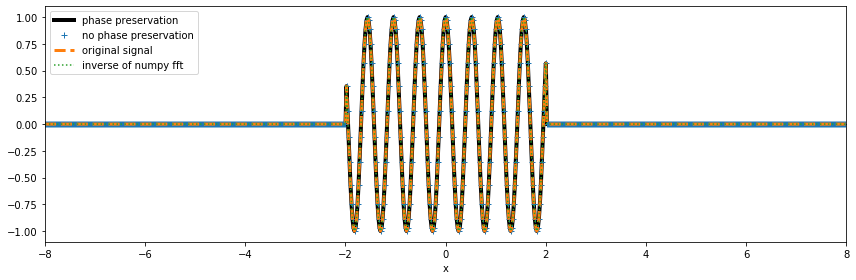

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
ida_dft.real.plot(ax=ax, linestyle='-', c='k', lw=4, label='phase preservation')
ax.plot(x, ida_fft.real, linestyle='', marker='+', label='no phase preservation') # w/out the phase information, the coordinates are lost
da.plot(ax=ax, ls='--', lw=3, label='original signal')
ax.plot(x, npft.ifft(da_npft).real, ls=':', label='inverse of numpy fft')
ax.set_xlim([-8,8])
ax.legend(loc='upper left')

# Now let's shift the coordinates so that they are not centered
This is where the xrft magic happens.

In [11]:
nx = 70                          # defining a shift
x0 = np.diff(x)[0]*nx 
nda = da.shift(x=nx).dropna('x')

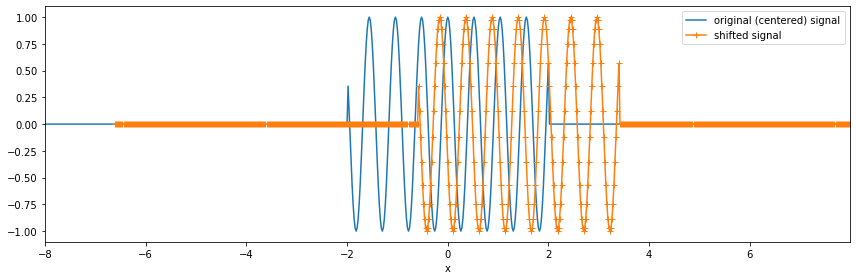

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
da.plot(ax=ax, label='original (centered) signal') 
nda.plot(ax=ax, marker='+', label='shifted signal') 
ax.set_xlim([-8,nda.x.max()])
ax.legend() 

## We consider again the Fourier transforms

In [14]:
nda_dft = xrft.dft(nda, true_phase=True, true_amplitude=True) # Fourier Transform w/ phase preservation 
nda_fft = xrft.fft(nda)                                       # Fourier Transform w/out phase preservation
nda_npft = npft.fft(nda)

In [15]:
nk = nda_dft.freq_x # wavenumber axis
TF_ns = T/2*(np.sinc(T*(nk-k0)) + np.sinc(T*(nk+k0)))*np.exp(-2j*np.pi*nk*x0) # Theoretical FT (Note the additional phase)

Text(0.5, 1.0, 'IMAGINARY PART')

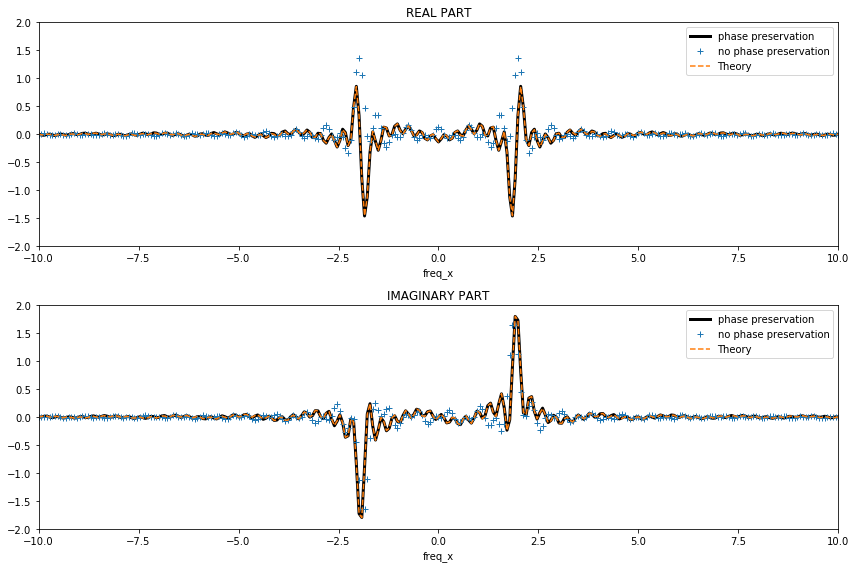

In [16]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,8), nrows=2, ncols=1)
fig.set_tight_layout(True)

(nda_dft.real).plot(ax=ax1, linestyle='-', lw=3, c='k', label='phase preservation') 
(r[nx:]*(nda_fft*dx).real).plot(ax=ax1, linestyle='', marker='+',label='no phase preservation') 
ax1.plot(nk, TF_ns.real, linestyle='--', label='Theory')
ax1.set_xlim([-10,10])
ax1.set_ylim([-2.,2])
ax1.legend()
ax1.set_title('REAL PART')

(nda_dft.imag).plot(ax=ax2, linestyle='-', lw=3, c='k', label='phase preservation') 
(r[nx:]*(nda_fft*dx).imag).plot(ax=ax2, linestyle='', marker='+', label='no phase preservation') 
ax2.plot(nk, TF_ns.imag, linestyle='--', label='Theory')
ax2.set_xlim([-10,10])
ax2.set_ylim([-2.,2.])
ax2.legend()
ax2.set_title('IMAGINARY PART')

The expected additional phase $e^{-i2 \pi k x_0}$ that appears in theory is well retreived with `xrft.dft` but not with `xrft.fft` nor `numpy.fft`.

## Now, let's take the inverse transform

In [17]:
inda_dft = xrft.idft(nda_dft, true_phase=True, true_amplitude=True) # Signal in direct space 
inda_fft = xrft.ifft(nda_fft)

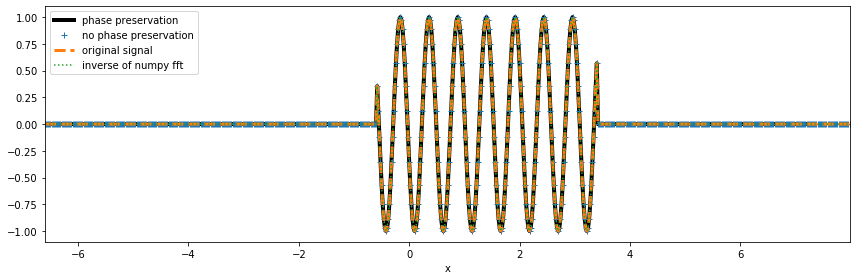

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
inda_dft.real.plot(ax=ax, linestyle='-', c='k', lw=4, label='phase preservation')
ax.plot(x[nx:], inda_fft.real, linestyle='', marker='+', label='no phase preservation')
nda.plot(ax=ax, ls='--', lw=3, label='original signal')
ax.plot(x[nx:], npft.ifft(nda_npft).real, ls=':', label='inverse of numpy fft')
ax.set_xlim([nda.x.min(),nda.x.max()])
ax.legend(loc='upper left')

Note that we are only able to match the inverse transforms of `xrft.ifft` and `numpy.ifft` to the data `ns` prior to being Fourier transformed because we "know" the original data `s` was shifted by `nx` datapoints as we see in `x[nx:]`. Using `xrft.idft` along with `xrft.dft` with the flags `true_phase=True` and `true_amplitude=True` automatically takes care of the information of shifted coordinates.

# Convention for real DFT
The default behavior of real DFTs in `xrft` are not compensated for one-sided spectra. To obtain scipy-like behavior for one-sided spectra, double the spectra.

In [35]:
da = xr.DataArray(np.random.normal(0, 1, size=100), 
                 dims=['x'], 
                 coords=[range(0,100)])

f_onesided, ps_onesided = signal.periodogram(da.values,
                                          window='rectangular')

ps = xrft.power_spectrum(da, dim='x', real='x', detrend='constant')

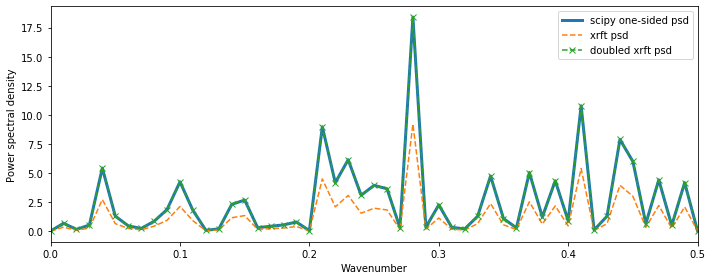

In [46]:
fig, ax = plt.subplots(figsize=(10,4))
fig.set_tight_layout(True)
ax.plot(f_onesided, ps_onesided, lw=3,
        label='scipy one-sided psd')

ax.plot(ps.freq_x, ps, 
        ls='--', label='xrft psd')
ax.plot(ps.freq_x, 2*ps, 
        ls='--', marker='x', label='doubled xrft psd')
ax.set_xlim([0.,.5])
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Power spectral density')
ax.legend()